<a href="https://colab.research.google.com/github/Jenniferli6/Adversarial_Patches/blob/main/Adversarial_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI Adversarial Patches
### Jennifer Li


Artificial intelligence (AI) systems have achieved remarkable accuracy in image recognition, speech processing, and decision-making. However, they remain surprisingly vulnerable to subtle manipulations. Tiny, human-imperceptible changes can cause models to misclassify objects with high confidence. To evaluate and strengthen the robustness of these systems, researchers use adversarial attacks, which intentionally fool machine learning models by crafting deceptive inputs.

In this project, I implemented an adversarial patch using a pretrained ResNet34 model on the [ImageNet100 dataset](https://www.kaggle.com/datasets/ambityga/imagenet100). The patch was trained to mislead the model into predicting a specific target class regardless of the original image content, demonstrating how easily deep networks can be deceived and highlighting the importance of building more resilient and trustworthy AI systems.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
import torch.nn.functional as F
from IPython.display import Image as IPImage, display
import random
import kagglehub
import requests
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set seed 42 for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# download ImageNet100 dataset
dataset_path = kagglehub.dataset_download("ambityga/imagenet100")
print(f"Dataset path: {dataset_path}")


Using Colab cache for faster access to the 'imagenet100' dataset.
Dataset path: /kaggle/input/imagenet100


In [4]:
# Configuration
TARGET_CLASS = 18  # class: magpie
PATCH_SIZE = (75, 75)
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
LR_DECAY = 0.95
NOISE_LEVEL = 0.05

print(f"\nConfiguration:")
print(f" Patch: {PATCH_SIZE}")
print(f" Epochs: {NUM_EPOCHS}")
print(f" Batch size: {BATCH_SIZE}")


Configuration:
 Patch: (75, 75)
 Epochs: 5
 Batch size: 32


In [5]:
# setup model
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url)
imagenet_classes = response.text.strip().split('\n')

model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model = model.to(device).eval()
for p in model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 220MB/s]


In [6]:
# load the data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# ⭐ Find all train folders (train.X1, train.X2, train.X3, train.X4)
train_folders = []
for item in os.listdir(dataset_path):
    if item.startswith("train."):
        folder_path = os.path.join(dataset_path, item)
        if os.path.isdir(folder_path):
            train_folders.append(folder_path)
            print(f"Found: {item}")

if not train_folders:
    raise ValueError(f"No train folders found in {dataset_path}")


Found: train.X1
Found: train.X3
Found: train.X4
Found: train.X2


In [7]:
# ⭐ Combine all train folders into one dataset
all_datasets = []
for train_path in train_folders:
    ds = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
    all_datasets.append(ds)
    print(f"  {os.path.basename(train_path)}: {len(ds)} images")

# Concatenate all datasets
dataset = torch.utils.data.ConcatDataset(all_datasets)
print(f"\nTotal images: {len(dataset)}")


  train.X1: 32500 images
  train.X3: 32500 images
  train.X4: 32500 images
  train.X2: 32500 images

Total images: 130000


In [8]:
# Limit to reasonable size for training
max_images = 5000
if len(dataset) > max_images:
    indices = torch.randperm(len(dataset))[:max_images]
    dataset = torch.utils.data.Subset(dataset, indices)
    print(f"Using: {len(dataset)} images for training")
else:
    print(f"Using all {len(dataset)} images for training")

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=4, drop_last=True)

Using: 5000 images for training


In [9]:
# define functions
def apply_patch_random(images, patch):
    batch_size = images.shape[0]
    h, w = PATCH_SIZE
    patched_images = images.clone()

    for i in range(batch_size):
        # Place patch at random position
        y = np.random.randint(0, 224 - h - 1)
        x = np.random.randint(0, 224 - w - 1)
        patched_images[i, :, y:y+h, x:x+w] = patch

    # Add noise to entire batch
    noise = torch.randn_like(patched_images) * NOISE_LEVEL
    patched_images = torch.clamp(patched_images + noise, 0, 1)

    return patched_images


def adversarial_loss(outputs, target_class):
    target_logit = outputs[:, target_class]
    other_logits = torch.cat([outputs[:, :target_class],
                              outputs[:, target_class+1:]], dim=1)
    max_other_logit = torch.max(other_logits, dim=1)[0]
    return (max_other_logit - target_logit).mean()


def total_variation_loss(patch):
    tv_h = torch.abs(patch[:, 1:, :] - patch[:, :-1, :]).mean()
    tv_w = torch.abs(patch[:, :, 1:] - patch[:, :, :-1]).mean()
    return tv_h + tv_w


In [10]:
# Training
print("\nTraining patch:")

from torch.nn import Parameter
patch = Parameter(torch.ones(3, PATCH_SIZE[0], PATCH_SIZE[1], device=device) * 0.5)

optimizer = torch.optim.Adam([patch], lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=LR_DECAY)

best_loss = float('inf')
best_patch = None

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    epoch_loss = 0
    num_batches = 0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Apply patch at random locations
        patched_images = apply_patch_random(images, patch)

        # Normalize and get predictions
        normalized = normalize(patched_images)
        outputs = model(normalized)

        # Loss: want all images to predict target class
        loss = adversarial_loss(outputs, TARGET_CLASS)

        # Add smoothness regularization
        loss += 0.01 * total_variation_loss(patch)

        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Clamp patch values
        with torch.no_grad():
            patch.data.clamp_(0, 1)

        epoch_loss += loss.item()
        num_batches += 1

        # Track best
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_patch = patch.data.clone()

        if (batch_idx + 1) % 50 == 0:
            print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} average loss: {avg_epoch_loss:.4f}")

# Use best patch
patch.data = best_patch
print("\nTraining complete!")


Training patch:

Epoch 1/5
  Batch 50/156, Loss: 3.9244
  Batch 100/156, Loss: 0.5993
  Batch 150/156, Loss: -4.7926
Epoch 1 average loss: 2.2026

Epoch 2/5
  Batch 50/156, Loss: -9.0645
  Batch 100/156, Loss: -11.5777
  Batch 150/156, Loss: -11.8184
Epoch 2 average loss: -10.0945

Epoch 3/5
  Batch 50/156, Loss: -13.6825
  Batch 100/156, Loss: -12.8102
  Batch 150/156, Loss: -15.1842
Epoch 3 average loss: -13.8151

Epoch 4/5
  Batch 50/156, Loss: -13.8860
  Batch 100/156, Loss: -14.5579
  Batch 150/156, Loss: -15.2826
Epoch 4 average loss: -14.8604

Epoch 5/5
  Batch 50/156, Loss: -17.6927
  Batch 100/156, Loss: -15.1691
  Batch 150/156, Loss: -15.3612
Epoch 5 average loss: -15.3739

Training complete!


In [11]:
# Initial Patch
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
initial_patch = np.ones((PATCH_SIZE[0], PATCH_SIZE[1], 3)) * 0.5
ax.imshow(initial_patch)
ax.set_title('Initial Patch', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig('initial_patch.png', dpi=150, bbox_inches='tight')
plt.close()

In [12]:
# Trained Patch
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
patch_display = patch.detach().cpu().permute(1, 2, 0).numpy()
patch_display = np.clip(patch_display, 0, 1)
ax.imshow(patch_display)
ax.set_title(f'Trained Patch\n{len(dataset)} images, {NUM_EPOCHS} epochs',
             fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig('trained_patch.png', dpi=150, bbox_inches='tight')
plt.close()


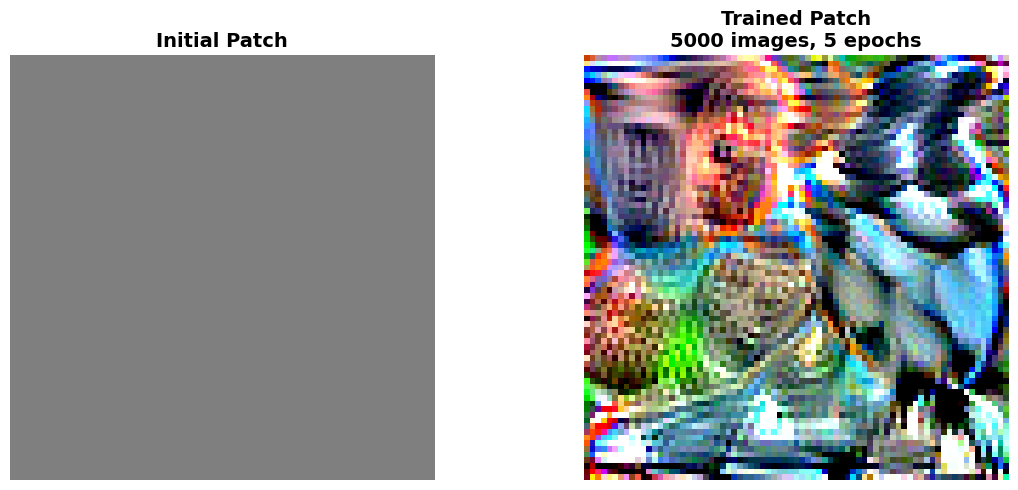

In [13]:
# Compare initial patch and trained patch
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(np.ones((PATCH_SIZE[0], PATCH_SIZE[1], 3)) * 0.5)
axes[0].set_title('Initial Patch', fontsize=14, fontweight='bold')
axes[0].axis('off')

patch_display = patch.detach().cpu().permute(1, 2, 0).numpy()
patch_display = np.clip(patch_display, 0, 1)
axes[1].imshow(patch_display)
axes[1].set_title(f'Trained Patch\n{len(dataset)} images, {NUM_EPOCHS} epochs',
                 fontsize=14, fontweight='bold')
axes[1].axis('off')
plt.tight_layout()
plt.savefig('patch_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Load 5 validation images
VAL_IMAGE_PATHS = [
    "val.X/n02006656/ILSVRC2012_val_00000043.JPEG",
    "val.X/n01443537/ILSVRC2012_val_00000994.JPEG",
    "val.X/n01877812/ILSVRC2012_val_00002971.JPEG",
    "val.X/n01491361/ILSVRC2012_val_00003204.JPEG",
    "val.X/n01531178/ILSVRC2012_val_00003816.JPEG"
]

test_images = []
test_labels = []
image_filenames = []

for img_path in VAL_IMAGE_PATHS:
    # Load image
    full_path = os.path.join(dataset_path, img_path)
    img = Image.open(full_path).convert('RGB')
    img_tensor = transform(img)

    # Get original classification
    with torch.no_grad():
        img_normalized = normalize(img_tensor.unsqueeze(0).to(device))
        outputs = model(img_normalized)
        predicted_class = torch.argmax(outputs).item()

    test_images.append(img_tensor)
    test_labels.append(predicted_class)
    image_filenames.append(os.path.basename(img_path))

    print(f"✓ {os.path.basename(img_path)}: {imagenet_classes[predicted_class]}")

print(f"\nTotal: {len(test_images)} images loaded\n")

✓ ILSVRC2012_val_00000043.JPEG: spoonbill
✓ ILSVRC2012_val_00000994.JPEG: goldfish
✓ ILSVRC2012_val_00002971.JPEG: wallaby
✓ ILSVRC2012_val_00003204.JPEG: tiger shark
✓ ILSVRC2012_val_00003816.JPEG: goldfinch

Total: 5 images loaded



In [15]:
# Test the trained adversarial patch
successes = 0
total = 0

for img in test_images:
    img = img.to(device)
    for _ in range(10):
        patched = apply_patch_random(img.unsqueeze(0), patch.detach()).squeeze(0)
        with torch.no_grad():
            normalized = normalize(patched)
            outputs = model(normalized.unsqueeze(0))
            pred = torch.argmax(outputs).item()
            if pred == TARGET_CLASS:
                successes += 1
            total += 1

print(f"Success rate: {successes}/{total} ({successes/total*100:.1f}%)\n")

Success rate: 50/50 (100.0%)



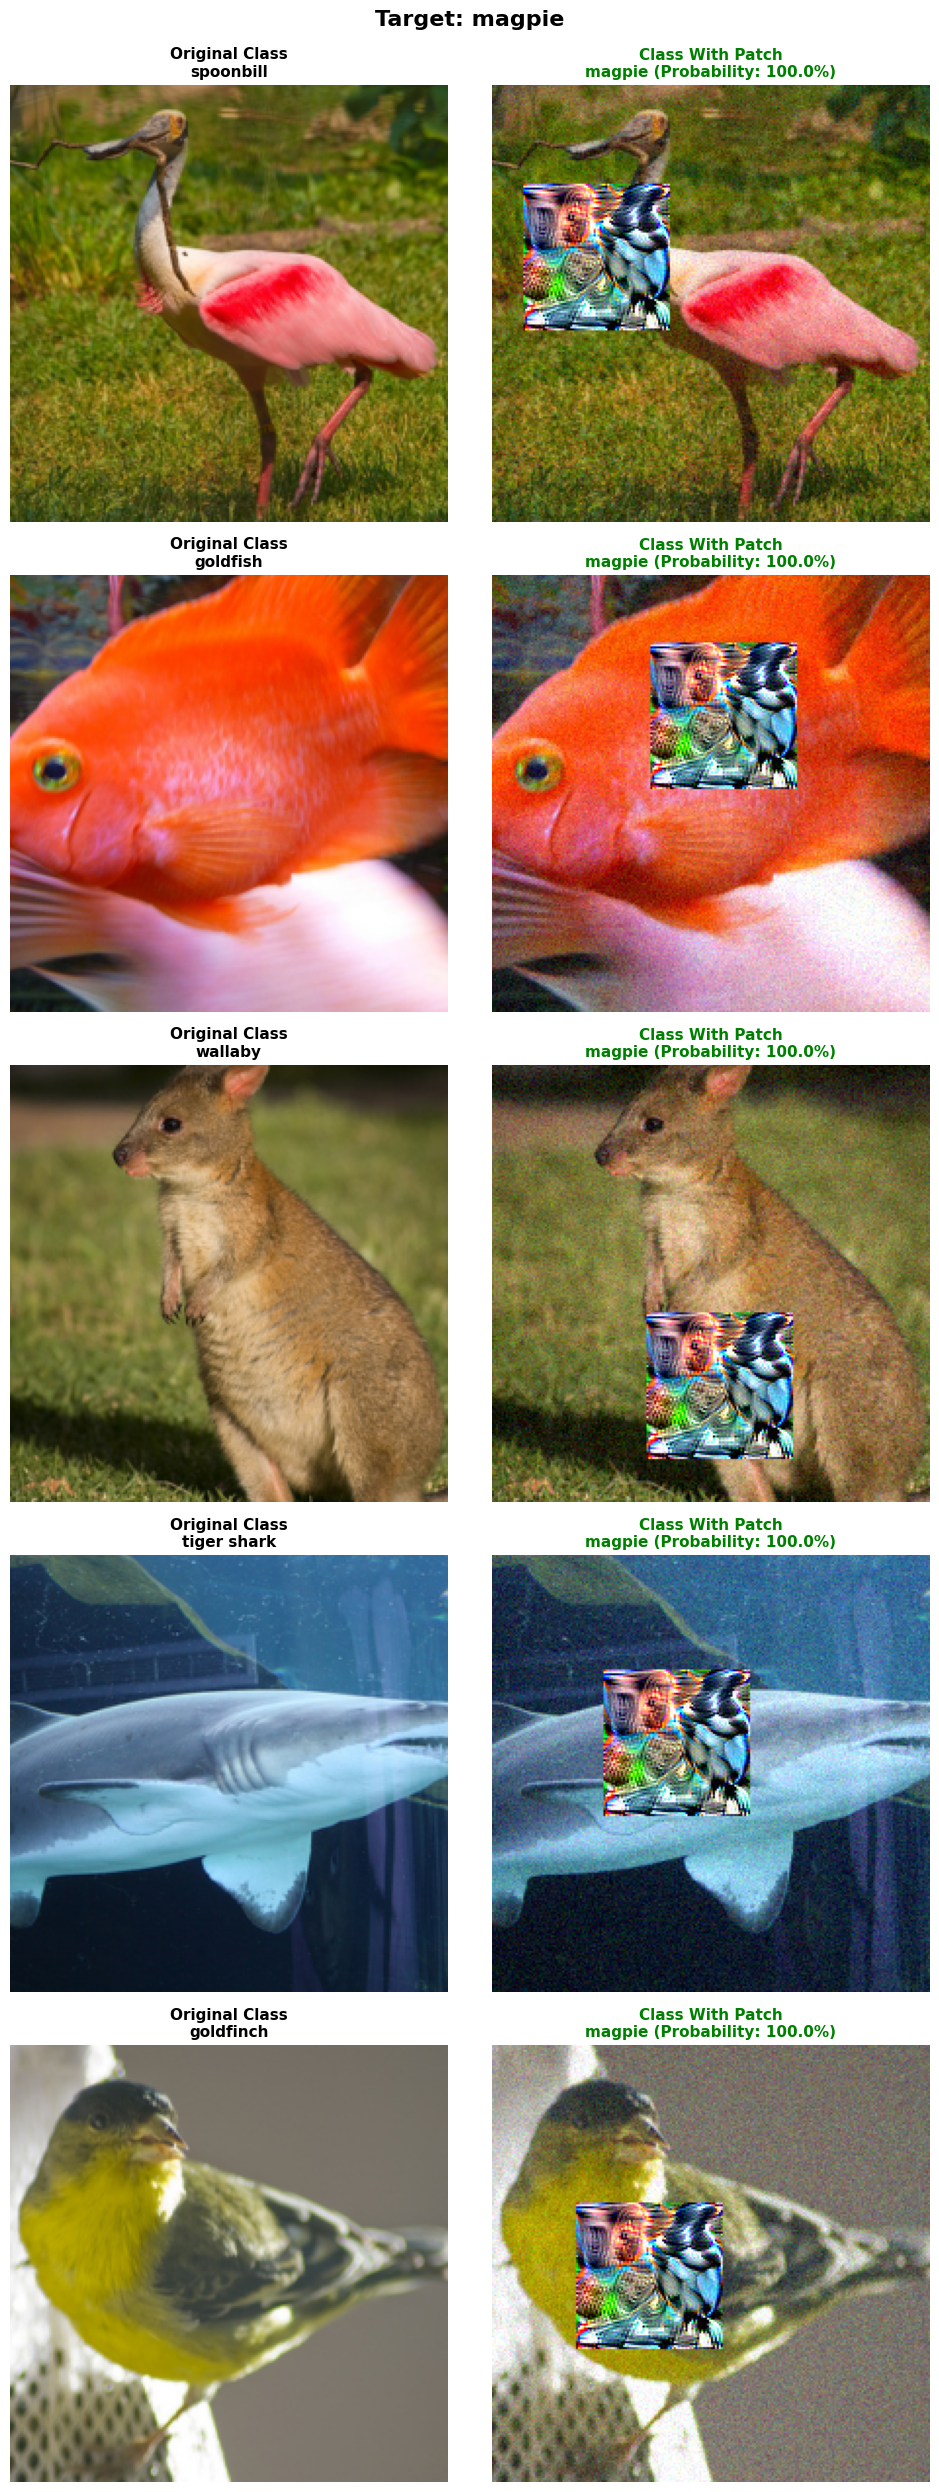

In [17]:
# Visualize the test result
fig, axes = plt.subplots(len(test_images), 2, figsize=(10, 5*len(test_images)))
if len(test_images) == 1:
    axes = axes.reshape(1, -1)

for i, img in enumerate(test_images):
    img = img.to(device)

    # Original
    img_display = img.cpu().permute(1, 2, 0).numpy()
    axes[i, 0].imshow(img_display)
    axes[i, 0].set_title(f'Original Class\n{imagenet_classes[test_labels[i]]}',
                         fontsize=11, fontweight='bold')
    axes[i, 0].axis('off')

    # With patch
    with torch.no_grad():
        patched = apply_patch_random(img.unsqueeze(0), patch.detach()).squeeze(0)
        patched_display = patched.cpu().permute(1, 2, 0).numpy()
        patched_display = np.clip(patched_display, 0, 1)

        normalized = normalize(patched)
        outputs = model(normalized.unsqueeze(0))
        pred = torch.argmax(outputs).item()
        prob = torch.softmax(outputs, dim=1)[0, pred].item()

    axes[i, 1].imshow(patched_display)
    color = 'green' if pred == TARGET_CLASS else 'red'
    axes[i, 1].set_title(f'Class With Patch\n{imagenet_classes[pred]} (Probability: {prob*100:.1f}%)',
                         fontsize=11, fontweight='bold', color=color)
    axes[i, 1].axis('off')

plt.suptitle(f'Target: {imagenet_classes[TARGET_CLASS]}',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('test_results.png', dpi=150, bbox_inches='tight')
plt.show()



### Real-world/Physical Patch Tests

To validate the adversarial patch in real-life settings, I printed and tested it across multiple physical scenes, including book with bird, bush and building, keyboard, microwave, pillow and chair, pool and building, and pumpkin. Each test confirmed that the printed patch consistently misled the model to classify the object as the target class magpie, demonstrating the patch’s effectiveness and robustness beyond digital environments.


#### 🎃 Pumpkin

![Pumpkin 1](./Real-life_Tests/Pumpkin%201.png)
![Pumpkin 2](./Real-life_Tests/Pumpkin%202.png)

#### 🍽️ Microwave

![Microwave 1](./Real-life_Tests/Microwave%201.png)
![Microwave 2](./Real-life_Tests/Microwave%202.png)

#### ⌨️ Keyboard

![Keyboard 1](./Real-life_Tests/Keyboard%201.png)
![Keyboard 2](./Real-life_Tests/Keyboard%202.png)

#### 📖 Book with Bird

![Book with Bird 1](./Real-life_Tests/Book%20with%20bird%201.png)
![Book with Bird 2](./Real-life_Tests/Book%20with%20bird%202.png)

#### 🛋️ Pillow & Chair

![Pillow & Chair 1](./Real-life_Tests/Pillow%20%26%20Chair%201.png)
![Pillow & Chair 2](./Real-life_Tests/Pillow%20%26%20Chair%202.png)

#### 🏢 Pool & Building

![Pool & Building 1](./Real-life_Tests/Pool%20%26%20Building%201.png)
![Pool & Building 2](./Real-life_Tests/Pool%20%26%20Building%202.png)

#### 🌿 Bush & Building

![Bush & Building 1](./Real-life_Tests/Bush%20%26%20Building%201.png)
![Bush & Building 2](./Real-life_Tests/Bush%20%26%20Building%202.png)




*Note: ChatGPT 5 and Claude Sonnet 4.5 were used to help debug the code and draft Github Repo ReadMe.*